In [20]:
!unzip "brain_mri.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_

In [12]:
!ls

drive  kaggle_3m  lgg-mri-segmentation	sample_data


In [21]:
import random
import os
import glob
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

plt.style.use("dark_background")

In [27]:
import torch

class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()

    NUM_CLASSES = 2
    EPOCHS = 100
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2
        else (32 * torch.cuda.device_count())
    )
    LR = 1e-4
    PATIENS = 8

    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

    # Define paths
    DATASET_PATH = "lgg-mri-segmentation/"
    TRAIN_PATH = 'lgg-mri-segmentation/kaggle_3m/'

# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [28]:
%%time
dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")
dataset_images[:5]

CPU times: user 18.6 ms, sys: 3.98 ms, total: 22.6 ms
Wall time: 23.1 ms


['lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_6.tif',
 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_17_mask.tif',
 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_5_mask.tif',
 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_29.tif',
 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_29_mask.tif']

In [29]:
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]


def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []

    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)

    return sample_numbers, is_mask


def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    # Create dataframe
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })

    # Return df
    return df

In [30]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'patient', 'image_path'])
    .reset_index(drop=True)
)

dataset_df

,id,patient,image_path,is_mask
0,1,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,0
1,1,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,1
2,1,TCGA_CS_4942_19970222,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19...,0
3,1,TCGA_CS_4942_19970222,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19...,1
4,1,TCGA_CS_4943_20000902,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20...,0
...,...,...,...,...
7853,87,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,1
7854,88,TCGA_HT_A61A_20000127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...,0
7855,88,TCGA_HT_A61A_20000127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...,1
7856,88,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0


In [31]:
# Group Samples by mask status
grouped_df = dataset_df.groupby(by='is_mask')

# Seperate Images from Masks
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True),
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

# Rename path column in mask df
mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

# View mask df
mask_df

,id,patient,mask_path
0,1,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...
1,1,TCGA_CS_4942_19970222,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19...
2,1,TCGA_CS_4943_20000902,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20...
3,1,TCGA_CS_4944_20010208,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20...
4,1,TCGA_CS_5393_19990606,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19...
...,...,...,...
3924,86,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...
3925,87,TCGA_HT_A61A_20000127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...
3926,87,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...
3927,88,TCGA_HT_A61A_20000127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...


In [32]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.


def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1 # Brain Tumor Present
    return 0 # Normal

In [33]:
# Merge images and mask df's
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)

# Generate MRI Label
ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]
ds

  0%|          | 0/3929 [00:00<?, ?it/s]

,id,patient,image_path,mask_path,diagnosis
0,1,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,0
1,1,TCGA_CS_4942_19970222,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19...,0
2,1,TCGA_CS_4943_20000902,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20...,0
3,1,TCGA_CS_4944_20010208,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20...,0
4,1,TCGA_CS_5393_19990606,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19...,0
...,...,...,...,...,...
3924,86,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0
3925,87,TCGA_HT_A61A_20000127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...,0
3926,87,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0
3927,88,TCGA_HT_A61A_20000127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...,0


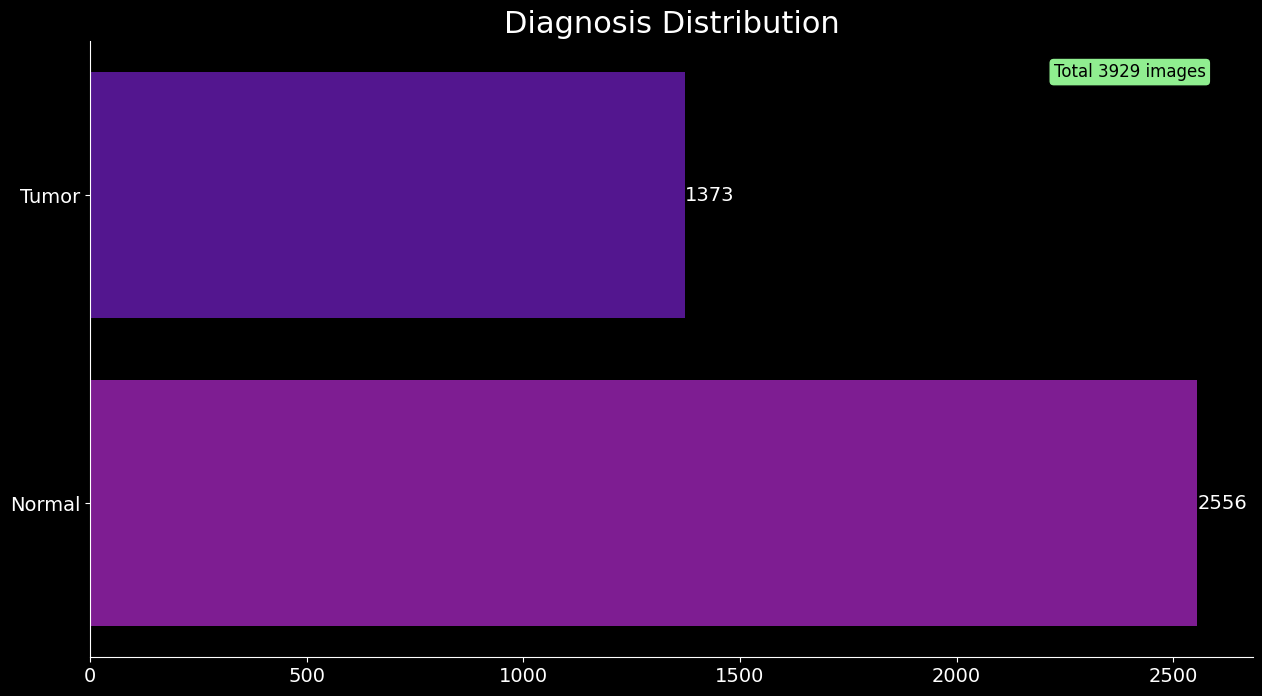

In [34]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(15, 8))
plt.title('Diagnosis Distribution', fontsize=22);

diagnosis_distribution = ds['diagnosis'].value_counts().sort_values()
diagnosis_map = {0: 'Normal', 1: 'Tumor'}

bar_plot = sns.barplot(
    x=diagnosis_distribution.values,
    y=[diagnosis_map[_] for _ in diagnosis_distribution.keys()],
    palette=sns.color_palette("plasma"),
    orient="h"
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

text_params = {
    'x'       : 2400,
    'y'       : -0.4,
    's'       : f"Total {len(ds)} images",
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center",
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);

sns.despine();

In [35]:
def view_sample(image, mask, color_map='rgb', fig_size=(16, 8), title_size=18):
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);

    # Plot MRI Image
    plt.subplot(1, 3, 1);
    plt.title(f'MRI Image', fontsize=title_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)

    # Plot Mask
    plt.subplot(1, 3, 2);
    plt.title(f'Mask', fontsize=title_size)
    plt.imshow(mask, cmap='gray');

    # Plot MRI w. Mask
    plt.subplot(1, 3, 3);
    plt.title(f'MRI + Mask', fontsize=title_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)

    plt.imshow(mask, cmap='gray', alpha=0.5);

    return

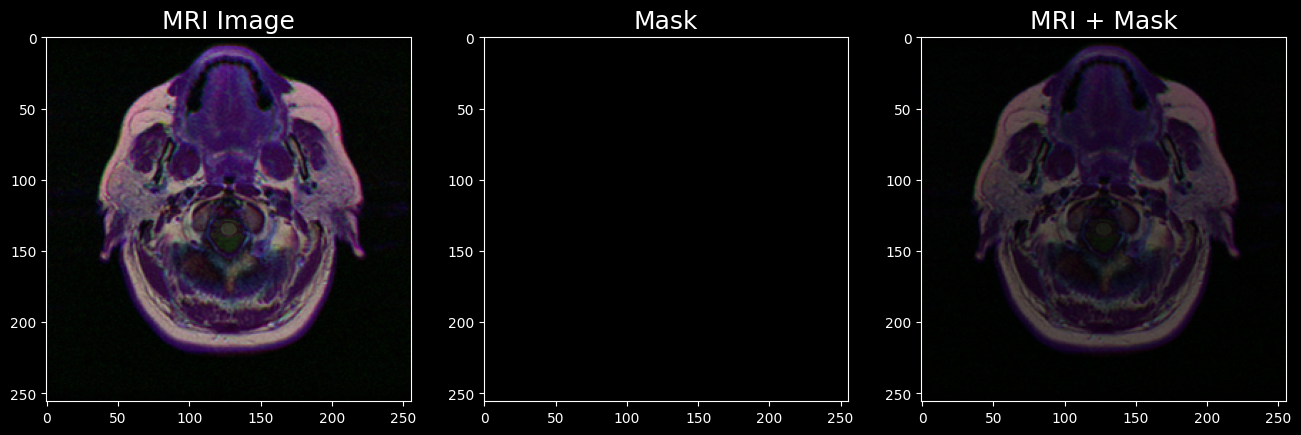

In [36]:
# Select random sample from train_df
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

# View the random sample
view_sample(
    sample_image,
    sample_mask,
    color_map='mako',
)


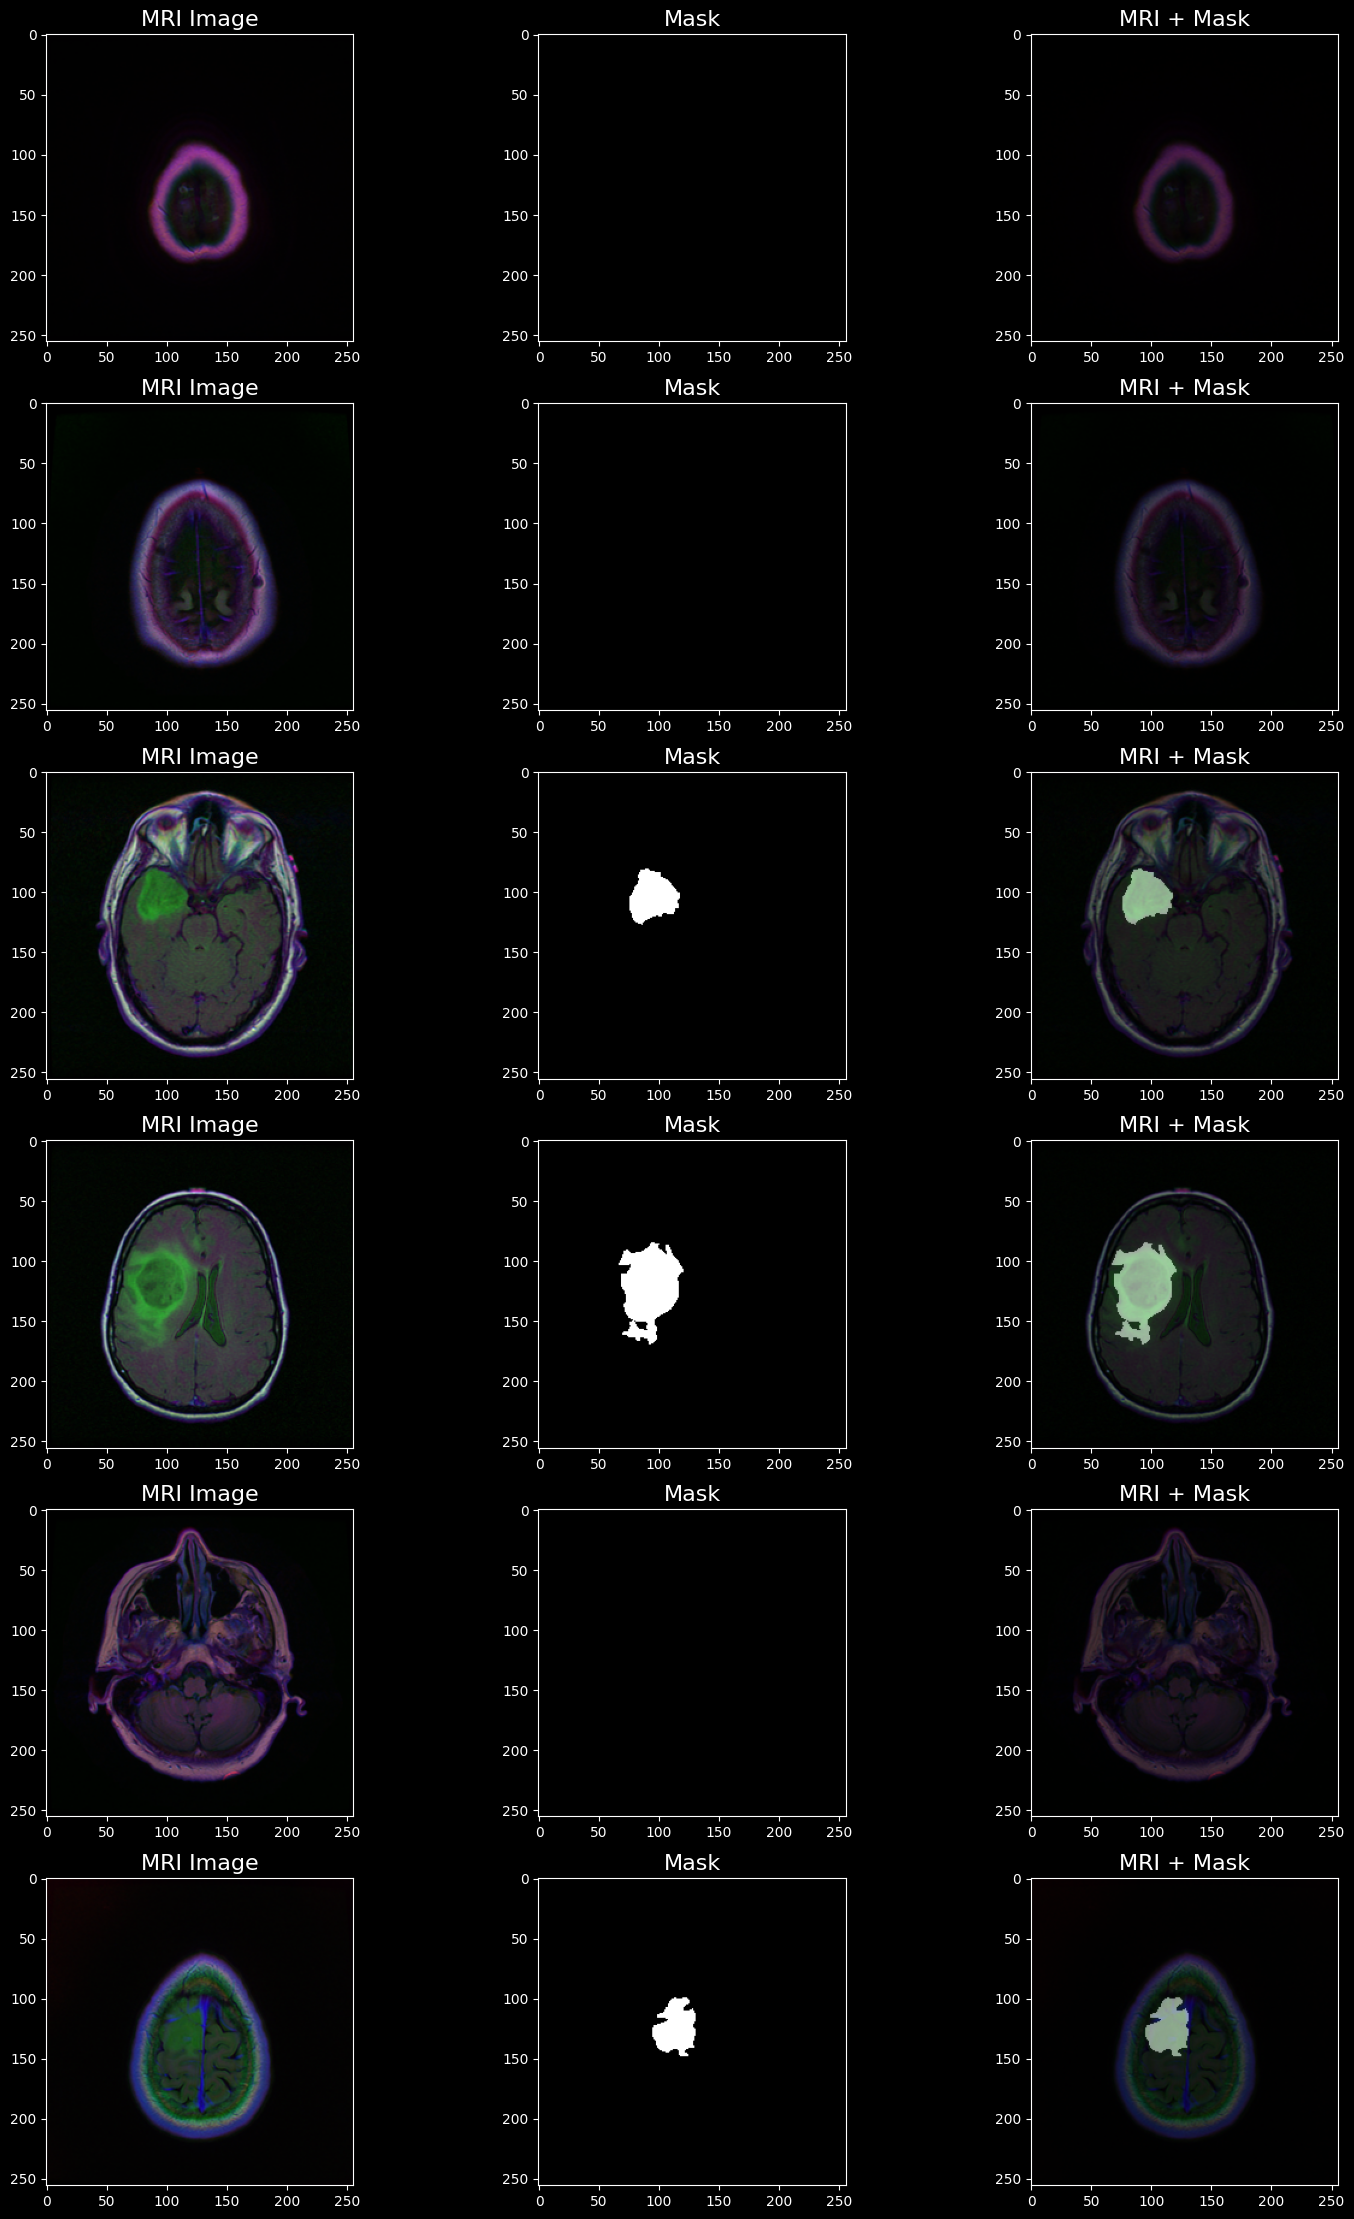

In [37]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10), title_size=16):
    idx = random.sample(df.index.to_list(), count)

    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);

    for row, _ in enumerate(idx):
        image, mask = (
            sample_loader(df.image_path[_]),#.permute(1, 2, 0),
            sample_loader(df.mask_path[_])#.permute(1, 2, 0)
        )

        idx = 3 * (row + 1)
        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1);
        plt.title(f'MRI Image', fontsize=title_size);
        if color_map=='rgb':
            plt.imshow(image)
        else:
            plt.imshow(image, cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2);
        plt.title(f'Mask', fontsize=title_size)
        plt.imshow(mask, cmap='gray');

        # Plot MRI w. Mask
        plt.subplot(count+1, 3, idx + 3);
        plt.title(f'MRI + Mask', fontsize=title_size)
        if color_map=='rgb':
            plt.imshow(image)
        else:
            plt.imshow(image, cmap=color_map)

        plt.imshow(mask, cmap='gray', alpha=0.5);

    return

# View 6 random sample images
view_mulitiple_samples(
    ds, _load,
    count=6, color_map='mako',
    fig_size=(18, 30)
)